# Ionization Equilibrium

Now that we're able to calculate the ionization and recombination rates easily, let's try to calculate the ionization equilibrium. We want to do this very efficiently. This method will live on the `Element` class. 

In [1]:
import os
os.environ['XUVTOP'] = '/Users/willbarnes/ssw/packages/chianti/dbase/'

import numpy as np
from scipy.interpolate import splev,splrep,interp1d
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn
import fiasco
import plasmapy
import ChiantiPy.tools as ch_tools
import ChiantiPy.core as ch
import hissw

%matplotlib inline

 using cli
 using CLI for selections


/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/ChiantiPy-0.7.dev673-py3.6.egg/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")


In [2]:
temperature = np.logspace(4,9,500)*u.K

In [3]:
el = fiasco.Element('iron',temperature)

In [4]:
ioneq = el.ionization_equilibrium()

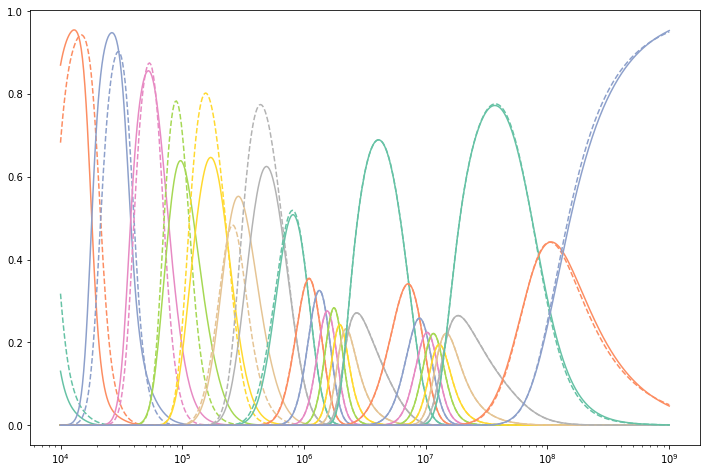

In [5]:
plt.figure(figsize=(12,8))
colors = seaborn.color_palette('Set2',n_colors=el.atomic_number+1)
for i,ion in enumerate(el):
    plt.plot(el.temperature,ion.ioneq,color=colors[i],ls='--')
    plt.plot(el.temperature,ioneq[:,i],color=colors[i])
plt.xscale('log')
#plt.xlim([1e6,1e7])

Solve ionization equilibrium equations 

In [ ]:
a_matrix = np.zeros(temperature.shape+(el.atomic_number+1,el.atomic_number+1))

In [ ]:
for i in range(1,el.atomic_number):
    a_matrix[:,i,i] = -(el[i].ionization_rate() + el[i].recombination_rate()).value
    a_matrix[:,i,i-1] = el[i-1].ionization_rate().value
    a_matrix[:,i,i+1] = el[i+1].recombination_rate().value
a_matrix[:,0,0] = -(el[0].ionization_rate() + el[0].recombination_rate()).value
a_matrix[:,0,1] = el[1].recombination_rate().value
a_matrix[:,-1,-1] = -(el[-1].ionization_rate().value + 
                                                  el[-1].recombination_rate().value)
a_matrix[:,-1,-1-1] = el[-1-1].ionization_rate().value

In [ ]:
uu,ss,vv = np.linalg.svd(a_matrix)

In [ ]:
yy = vv[:,-1,:]
yy = np.fabs(yy)
#yy = np.where(yy<0,0,yy)
yy /= np.sum(yy,axis=1)[:,np.newaxis]

In [ ]:
plt.figure(figsize=(10,10))
colors = seaborn.color_palette('Set2',n_colors=el.atomic_number+1)
for i in range(el.atomic_number+1):
    plt.plot(temperature,el[i].ioneq,'--',color=colors[i])
    plt.plot(temperature,yy[:,i],color=colors[i])
plt.xscale('log')
#plt.xlim([1e6,5e6])
#plt.ylim([0,0.5])

## ChiantiPy Comparison

In [6]:
ioneq1 = ch.ioneq('fe')
ioneq1.load()

In [7]:
ioneq2 = ch.ioneq('fe')
ioneq2.calculate(temperature.value)

/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/ChiantiPy-0.7.dev673-py3.6.egg/ChiantiPy/core/Ion.py:742: RuntimeWarning: invalid value encountered in greater
  gcoef = drenergy > 0.


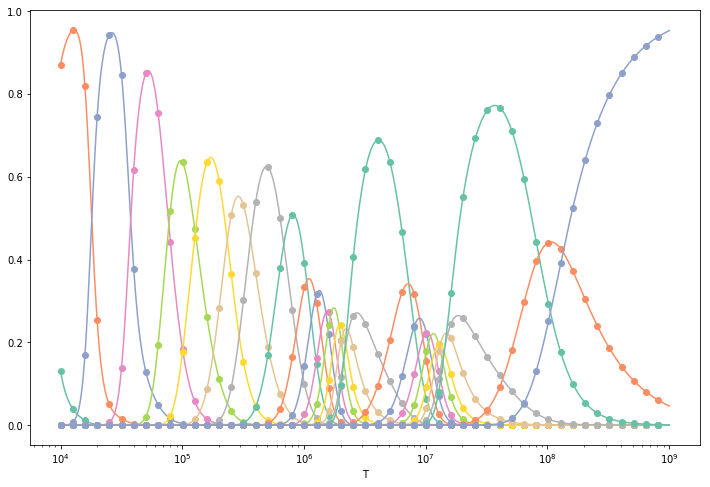

In [9]:
plt.figure(figsize=(12,8))
colors = seaborn.color_palette('Set2',n_colors=el.atomic_number+1)
for i in range(el.atomic_number+1):
    plt.plot(temperature,ioneq2.Ioneq[i,:],'o',ls='',markevery=10,color=colors[i],label='ChiantiPy')
    plt.plot(temperature,ioneq[:,i],color=colors[i],label=r'fiasco')
plt.xscale('log')
#plt.xlim([1e5,3e6])
plt.xlabel(r'T')
#plt.legend()

In [ ]:
#plt.plot(temperature,np.fabs(ioneq2.Ioneq[6,:] - ioneq[:,6])/(0.5*(ioneq2.Ioneq[6,:] + ioneq[:,6])))
plt.plot(temperature,np.fabs(ioneq2.Ioneq[7,:] - ioneq[:,7])/(0.5*(ioneq2.Ioneq[7,:] + ioneq[:,7])))
plt.plot(temperature,np.fabs(ioneq2.Ioneq[8,:] - ioneq[:,8])/(0.5*(ioneq2.Ioneq[8,:] + ioneq[:,8])))
plt.xscale('log')
#plt.xlim([1e5,1e7])
plt.ylim([0,1])

In [ ]:
ioneq.shape

In [ ]:
plt.figure(figsize=(10,10))
colors = seaborn.color_palette('Set2',n_colors=el.atomic_number+1)
for i in range(el.atomic_number+1):
    plt.plot(ioneq1.Temperature,ioneq1.Ioneq[i,:],'--',color=colors[i])
    plt.plot(temperature,ioneq2.Ioneq[i,:],color=colors[i])
plt.xscale('log')

## Comparing Ionization and Recombination Rates

In [ ]:
ssw_script = """
temperature = {{temperature}}
rrate = recomb_rate('fe_8',temperature)
"""

In [ ]:
ssw_runner = hissw.ScriptMaker(ssw_packages=['chianti'],ssw_paths=['chianti'])

In [ ]:
ssw_res = ssw_runner.run([(ssw_script,{'temperature':temperature.value.tolist()})],verbose=True)

In [ ]:
foo = ch.ion('fe_7',temperature.value)
foo.ionizRate()
foo.recombRate()
bar = ch.ion('fe_8',temperature.value)
bar.ionizRate()
bar.recombRate()

In [ ]:
plt.plot(temperature,el[6].ionization_rate())
plt.plot(temperature,el[7].ionization_rate())
plt.plot(temperature,foo.IonizRate['rate'],'o',markevery=10)
plt.plot(temperature,bar.IonizRate['rate'],'o',markevery=10)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-15,1e-7])

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(temperature,el[6].recombination_rate(),label=6)
plt.plot(temperature,el[7].recombination_rate(),label=7)
plt.plot(temperature,foo.RecombRate['rate'],'o',markevery=10,label=6)
plt.plot(temperature,bar.RecombRate['rate'],'o',markevery=10,label=7)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-15,1e-7])
plt.legend()

In [ ]:
plt.plot(temperature,el[6].radiative_recombination_rate(),label=r'radiative')
plt.plot(temperature,el[6].dielectronic_recombination_rate(),label=r'dielectronic')
plt.plot(temperature,foo.RrRate['rate'],'o',markevery=20,label='radiative')
plt.plot(temperature,foo.DrRate['rate'],'o',markevery=20,label='dielectronic')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(temperature,el[7].recombination_rate(),label=r'total w/ last term',color='b')
plt.plot(temperature,el[7].dielectronic_recombination_rate(),label=r'DI w/ last term',ls='--',color='b')
plt.plot(temperature,bar.RecombRate['rate'],'-',markevery=20,label='total w/o last term',color='r')
plt.plot(temperature,bar.DrRate['rate'],'--',markevery=20,label='DI w/o last term',color='r')
plt.plot(ssw_res['temperature'],ssw_res['rrate'],'ko',markevery=20,label='CHIANTI IDL')
plt.xlabel(r'T')
plt.ylabel(r'Recombination Rate')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-12,2e-10])
plt.legend()

In [ ]:
bar.DrParams

In [ ]:
bar.DrParams['eparams']

In [ ]:
foo.DrParams

In [ ]:
foo.DrParams['eparams']

In [ ]:
%%bash
head -n 100 /Users/willbarnes/ssw/packages/chianti/dbase/fe/fe_8/fe_8.drparams